## Simpson Character Classifier

The dataset are accessible through
https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset


Aim: Build a model that could accurately identify character's name inside an image. Challenges arise in this project mainly comes from the randomness of the dataset where for each character, they are presented in a variety of situations with different backgrounds, different angles, etc.

In [1]:
import tensorflow as tf 
import numpy as np            
import matplotlib.pyplot as plt         
import os 
import copy 
import itertools 
from tensorflow import keras 
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.preprocessing.image import ImageDataGenerator             
from PIL import Image             
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

In [2]:
# Connect Drive to Colab
try:
  from google.colab import drive
  drive.mount('/content/drive')
  has_colab=True
except ImportError:
  has_colab=False

if has_colab:
  import os
  default_path='/content/drive/MyDrive/Detecting_Character'
  os.chdir(default_path)
else:
  os.chdir('/..')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

In [3]:
train_path = '/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/simpsons_dataset/'
test_path = '/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/kaggle_simpson_testset/kaggle_simpson_testset/'

In [4]:
os.chdir(train_path)
num_classes = len(os.listdir(train_path)) # How many classes are there?
characters = sorted(os.listdir(train_path)) # List of characters
print(num_classes) 

20


### Loading Training Set

In [13]:
img_size = (112,112)
# data = []
# labels = []

# for i in characters:     
#     path = train_path + '/' + i
#     images = sorted(os.listdir(path))

#     for file in images:   
#         try:
#             image = Image.open(path + '/' + file)
#             image = image.resize(img_size)   
#             image = np.array(image)
#             data.append(image)
#             labels.append(i)        
#         except:
#             print(f'Error loading image, character: {i}, file: {file}')

# data = np.array(data)
# labels = np.array(labels)

# Saving the numpy arrays 
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_train_set.npy', data)
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_train_set.npy', labels)
     

In [18]:
data = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_train_set.npy')
labels = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_train_set.npy')
print(data.shape)
print(labels.shape)

(19548, 112, 112, 3)
(19548,)


In [19]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
del data # Remove this to save RAM
del labels # Remove this to save RAM

In [20]:
# Checking Dimensions
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(15638, 112, 112, 3)
(15638,)
(3910, 112, 112, 3)
(3910,)


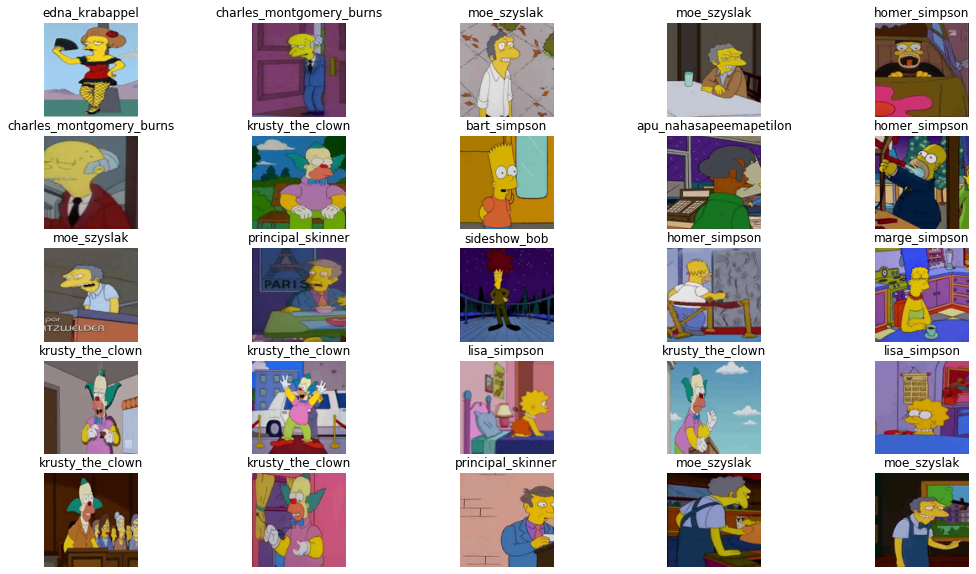

In [21]:
# Plotting Image
fig = plt.figure(figsize=(18, 10))
cols = 5
rows = 5
for i in range(1, cols*rows + 1):
    img = X_train[i,:,:,:]
    lb = y_train[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(lb)
    plt.axis('off')
plt.show()

### Loading Test Set

In [25]:
# test_data = []
# test_labels = []

# for i in sorted(os.listdir(test_path)):
#     path = test_path + '/' + i
#     image = Image.open(path)
#     image = image.resize(img_size)
#     image = np.array(image)
#     test_data.append(image)
#     split_label = i.split('_') 
#     label = '_'.join(split_label[:-1]) 
#     test_labels.append(label) 

# test_data = np.array(test_data)
# test_labels = np.array(test_labels)

In [26]:
# Saving the numpy arrays 
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_test_set.npy', test_data)
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_test_set.npy', test_labels)
# del test_data # Remove this to save RAM
# del test_labels # Remove this to save RAM

In [27]:
# Load test set
X_test = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_test_set.npy')
y_test = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_test_set.npy')
print(X_test.shape)
print(y_test.shape)

(990, 112, 112, 3)
(990,)


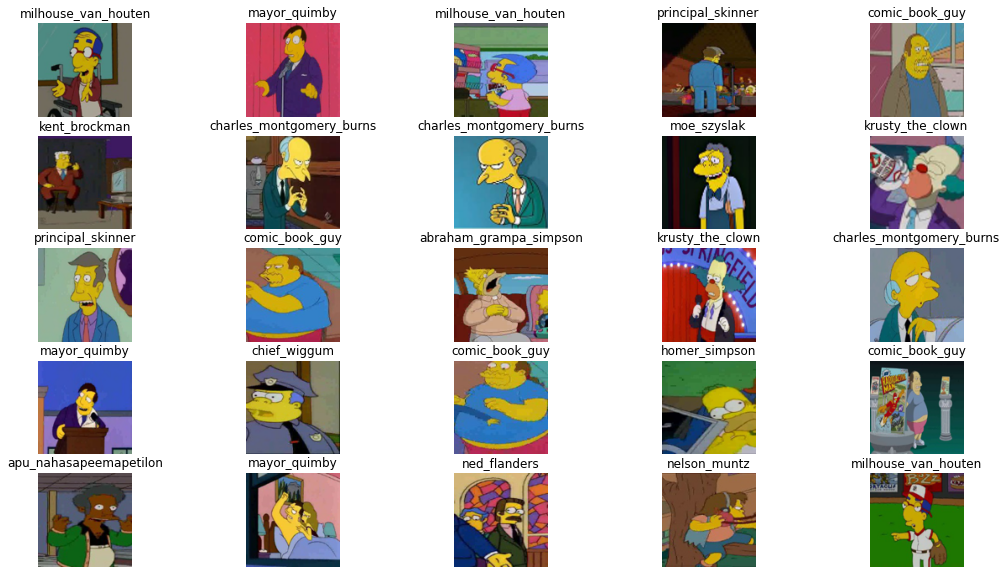

In [28]:
# Plotting test set images

fig = plt.figure(figsize=(18, 10))
cols = 5
rows = 5
for i in range(1, cols*rows + 1):
    random_number = np.random.randint(990) # To index random images
    img = X_test[random_number,:,:,:]
    lb = y_test[random_number]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(lb)
    plt.axis('off')
plt.show()

## Data Preprocessing 

### Label Processing

Labels in the dataset are categorical while model needs the label to be a number. Solution for this is to do one-hot encoding to represent the classes. One-hot encoding was done because it avoids order of classes. LabelEncoder from Sklearn and to_categorical from Keras was used since it helps us to encode these labels for us.

In [29]:
classes = sorted(list(set(characters)))
print("Test set labels", np.array(classes).shape, "\n")
classes

Test set labels (20,) 



['abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'comic_book_guy',
 'edna_krabappel',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lisa_simpson',
 'marge_simpson',
 'mayor_quimby',
 'milhouse_van_houten',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'principal_skinner',
 'sideshow_bob']

In [16]:
def one_hot_classes(y, names):
  encoder = LabelEncoder()
  int_class = encoder.fit_transform(y)
  output = to_categorical(int_class, num_classes=len(names))
  return output

In [17]:
y_train_hot = one_hot_classes(y_train, classes)
y_val_hot = one_hot_classes(y_val, classes)
y_test_hot = one_hot_classes(y_test, classes)

In [18]:
# Normalize Data
X_train = (X_train/255).astype(np.float32)
X_validation = (X_val/255).astype(np.float32)
X_test = (X_test/255).astype(np.float32)

## Building Deep Learning Models

### CNN Model


In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 5, activation='relu', padding='valid', input_shape=X_train[0].shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 108, 108, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

## Preventing Overfitting
Early stopping was done to reduce the chance for the model to overfit the training data.

In [21]:
earlystopping = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 monitor='val_accuracy', 
                                                 mode='max')
h = model.fit(X_train, y_train_hot, 
              validation_data=(X_validation, y_val_hot), epochs=10, 
              batch_size=64)

Epoch 1/10
262/262 [==============================] - 16s 28ms/step - loss: 3.1981 - accuracy: 0.0988 - val_loss: 4.3370 - val_accuracy: 0.0308
Epoch 2/10
262/262 [==============================] - 6s 23ms/step - loss: 2.7602 - accuracy: 0.2173 - val_loss: 5.1719 - val_accuracy: 0.1046
Epoch 3/10
262/262 [==============================] - 6s 23ms/step - loss: 2.0589 - accuracy: 0.4208 - val_loss: 7.6709 - val_accuracy: 0.1397
Epoch 4/10
262/262 [==============================] - 6s 24ms/step - loss: 1.5696 - accuracy: 0.5626 - val_loss: 8.6004 - val_accuracy: 0.1660
Epoch 5/10
262/262 [==============================] - 8s 31ms/step - loss: 1.2774 - accuracy: 0.6408 - val_loss: 9.1319 - val_accuracy: 0.1736
Epoch 6/10
262/262 [==============================] - 7s 26ms/step - loss: 1.0883 - accuracy: 0.6880 - val_loss: 11.4265 - val_accuracy: 0.1961
Epoch 7/10
262/262 [==============================] - 6s 23ms/step - loss: 0.9018 - accuracy: 0.7420 - val_loss: 12.5339 - val_accuracy: 0.1